In [113]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [114]:
# load saved files
caps = pd.read_csv('stocks_market_caps.csv', index_col = 'Ticker')
stock_monthly = pd.read_csv('stock_monthly.csv', index_col = 0)
# 这两个退市

caps.drop('BRK.B', inplace = True)
caps.drop('BF.B', inplace = True)
caps.drop('LVS', inplace = True)
# 这三个新上市
caps.drop('VLTO', inplace = True)
caps.drop('KVUE', inplace = True)
caps.drop('GEHC', inplace = True)

# ticker index
sp500_tickers = caps.index

index_return = pd.read_csv('index_monthly.csv', index_col = 0)
time = index_return.index.tolist()
# use recent years
one_year = time[6:18]

In [118]:
def redistribute_holdings_pandas_updated(holdings_series, max_limit):
    """
    Redistribute stock holdings provided as a pandas Series to ensure no stock exceeds the max limit.
    Excess is redistributed based on the original proportion of holdings for all stocks.

    :param holdings_series: Pandas Series with stock holdings (index: stock, values: percentage)
    :param max_limit: Maximum limit for a single stock holding as a decimal (e.g., 0.30 for 30%)
    :return: Pandas Series with redistributed stock holdings
    """
    # Sort the holdings by value in descending order
    sorted_holdings = holdings_series.sort_values(ascending=False)

    # Initialize variables
    excess = 0
    updated_holdings = pd.Series(index=sorted_holdings.index)

    # Calculate excess and assign max limit to stocks exceeding the limit
    for stock in sorted_holdings.index:
        if sorted_holdings[stock] > max_limit:
            excess += sorted_holdings[stock] - max_limit
            updated_holdings[stock] = max_limit
        else:
            updated_holdings[stock] = sorted_holdings[stock]

    # Proportional distribution of excess based on original holdings
    for stock in sorted_holdings.index:
        proportional_allocation = (sorted_holdings[stock] / holdings_series.sum()) * excess
        updated_holdings[stock] += min(proportional_allocation, max_limit - updated_holdings[stock])

    # Normalize to ensure the total adds up to 1 (100%)
    normalization_factor = updated_holdings.sum()
    updated_holdings /= normalization_factor

    return updated_holdings

# Example usage
redistributed_holdings_updated = redistribute_holdings_pandas_updated(holdings_series, max_limit)
redistributed_holdings_updated



A    0.314214
B    0.311721
C    0.187032
D    0.124688
E    0.062344
dtype: float64

,SP500 Return
2022-06-30,-0.083920
2022-07-31,0.091116
2022-08-31,-0.042440
2022-09-30,-0.093396
2022-10-31,0.079863
2022-11-30,0.053753
2022-12-31,-0.058971
2023-01-31,0.061753
2023-02-28,-0.026112
2023-03-31,0.035052


In [174]:
def index_fund(one_year, k_no, subset, proportion, adjusted): 
    portfolio_rts = []
    index_rts = []
    for i in range(len(one_year)):

        # data process
        date = one_year[i]
        df1 = pd.DataFrame()
        volas = pd.Series(dtype='object')
        returns  = pd.Series(dtype='object')
        val = stock_monthly.loc[date]
        for t in sp500_tickers:
            volas[t] = val[t+' Vola']
            returns[t] = val[t+ ' Return']
        df1['Vola'] = volas
        df1['Return'] = returns
        data = pd.concat([caps, df1], axis=1)

        # if not first month, start examning performance!
        if i > 0:
            print("the portfolio weight is: ",adjusted_weight)
            portfolio_rt = 0
            for stock in adjusted_weight.index:
                portfolio_rt += adjusted_weight[stock]*data['Return'][stock]
                
            index_rt = index_return['SP500 Return'][date] 
            print(date, "portfolio return is: ",portfolio_rt, " and index return is: ", index_rt)
            portfolio_rts.append(portfolio_rt)
            index_rts.append(index_rt)
          
        # last month, no need to calculate, because cannot compare, just report yearly tracking error
        if i == (len(one_year)-1):
            # Convert lists to pandas Series
            portfolio_series = pd.Series(portfolio_rts)
            index_series = pd.Series(index_rts)

            # Calculate the differences
            differences = portfolio_series - index_series

            # Calculate the tracking error as the standard deviation of the differences
            tracking_error = differences.std()

            print("The yearly tracking error is", tracking_error)
            break;
        
            
        
        # Finding the index of NaN values
    #     nan_indexes = df1[df1.isna().any(axis=1)].index

    #     print("Indexes with NaN values:", date, nan_indexes)
        scaler = StandardScaler()
        data_subset = data[subset]
        data_scaled_subset = scaler.fit_transform(data_subset)

        # Create and fit the KMeans model
        kmeans = KMeans(n_clusters=k_no)
        kmeans.fit(data_scaled_subset)

        # Get centroids
        centroids = kmeans.cluster_centers_
        
    # Initialize a dictionary to store the closest points
        closest_points = {}

        for i, centroid in enumerate(centroids):
            # Calculate distances of all points in df1_scaled to this centroid
            distances = np.linalg.norm(data_scaled_subset - centroid, axis=1)
        
            # Find the index of the minimum distance
            closest_point_idx = np.argmin(distances)
            
        # Map this index to the original DataFrame's index
            closest_points[f'Centroid_{i}'] = df1.index[closest_point_idx]
        
        result_centroid = []
        # Print the closest points to each centroid
        for centroid, point in closest_points.items():
            result_centroid.append(point)
        
        print(date, "the portfolio is: ",result_centroid)
        #     print(f"{centroid}: Closest point is '{point}' from the original DataFrame.")
        df_filtered = data.loc[result_centroid]
        
        # Calculate the total market capitalization
        total_market_cap = df_filtered['Market Cap'].sum()

        
        # Calculate the weight of each ticker
        df_filtered['Weight'] = df_filtered['Market Cap'] / total_market_cap
        if adjusted:
            adjusted_weight = redistribute_holdings_pandas_updated(df_filtered['Weight'], proportion)
        else: 
            adjusted_weight = df_filtered['Weight'].sort_values(ascending=False)
            
        # The 'Weight' column now contains the weight of each ticker based on market cap


In [168]:
data

,Market Cap,Vola,Return
MMM,5.709301e+10,0.010903,0.099720
AOS,1.159867e+10,0.011273,0.076548
ABT,1.814356e+11,0.009862,0.096034
ABBV,2.635598e+11,0.008130,-0.018983
ACN,2.118209e+11,0.009776,0.122017
...,...,...,...
YUM,3.485349e+10,0.009435,0.043469
ZBRA,1.212754e+10,0.026625,0.129829
ZBH,2.451347e+10,0.015895,0.091083
ZION,5.767440e+09,0.030230,0.162765


In [171]:
# 使用方法，第一个是时间，（n+1月能出n月报告），第二个是K的数量，20，30，50，第三个是用几个尺度做kmean，目前就三个，['Vola', 'Return', 'Market Cap'], 第四个是均衡权重指数，第五个是是否开启均衡权重
index_fund(one_year, 50,['Vola', 'Return'], 0.05, True)

2022-12-31 the portfolio is:  ['WTW', 'CTRA', 'TECH', 'MLM', 'CHTR', 'CAT', 'FICO', 'BX', 'APA', 'UNP', 'POOL', 'EPAM', 'TSLA', 'CPB', 'ROL', 'MRNA', 'GOOGL', 'PSX', 'PANW', 'CAG', 'NRG', 'NVDA', 'BKR', 'WY', 'SO', 'HOLX', 'TER', 'EQR', 'XRAY', 'TRMB', 'SEDG', 'AOS', 'HAL', 'AKAM', 'MAS', 'PM', 'FOXA', 'AMD', 'BBWI', 'NCLH', 'ZION', 'IFF', 'CTLT', 'OMC', 'KIM', 'WBD', 'DE', 'CTAS', 'AWK', 'DLR']
the portfolio weight is:  GOOGL    0.077006
NVDA     0.077006
TSLA     0.077006
AMD      0.077006
PM       0.060388
UNP      0.059671
BX       0.058005
CAT      0.056280
DE       0.044620
PANW     0.040085
SO       0.033221
CTAS     0.024010
PSX      0.023489
CHTR     0.023162
DLR      0.017765
BKR      0.013917
HAL      0.013319
MRNA     0.013047
MLM      0.012359
FICO     0.011943
WBD      0.011916
AWK      0.010895
WTW      0.010675
WY       0.009600
EQR      0.009515
ROL      0.008543
IFF      0.008354
CTRA     0.007915
AKAM     0.007352
HOLX     0.006991
OMC      0.006909
EPAM     0.006600

the portfolio weight is:  MA      0.060051
PG      0.060051
MRK     0.060051
BAC     0.060051
AMD     0.060051
TMUS    0.060051
AMAT    0.060051
T       0.060051
ANET    0.037661
HUM     0.032040
APD     0.031612
COF     0.024303
TEL     0.022389
NUE     0.021533
GIS     0.020564
HSY     0.020525
OTIS    0.019351
URI     0.018133
BKR     0.017652
RCL     0.016680
IR      0.016036
KEYS    0.013617
CCL     0.012783
ETR     0.011657
BRO     0.011403
NVR     0.011228
EXPE    0.010917
JBHT    0.010401
PPL     0.010380
NTAP    0.009952
STLD    0.009895
AXON    0.009571
CMS     0.009168
RF      0.008765
FSLR    0.008394
EPAM    0.008372
JKHY    0.006481
NRG     0.005833
WRK     0.005704
BXP     0.005434
CZR     0.005151
AAL     0.004859
BBWI    0.004587
NCLH    0.004294
BWA     0.004179
TPR     0.004153
GNRC    0.004035
VFC     0.003812
CTLT    0.003622
ALK     0.002464
dtype: float64
2023-07-31 portfolio return is:  0.017590744681331257  and index return is:  0.0311389323550108
2023-07-31 th

In [179]:
# 使用方法，第一个是K的数量，20，30，50，第二个是用几个尺度做kmean，目前就三个，['Vola', 'Return', 'Market Cap'], 第三个是均衡权重指数，第四个是是否开启均衡权重
index_fund(one_year, 50,['Vola', 'Return'], 0.05, False)

2022-12-31 the portfolio is:  ['BX', 'LH', 'FOX', 'BKR', 'TROW', 'CDAY', 'RTX', 'BKNG', 'MRNA', 'SWKS', 'KIM', 'GM', 'AKAM', 'TSLA', 'OMC', 'CMCSA', 'DE', 'HAL', 'CHTR', 'AAL', 'EL', 'PARA', 'DLR', 'MMM', 'NCLH', 'ABBV', 'TER', 'CAT', 'MS', 'NRG', 'AEE', 'CTAS', 'ANET', 'UPS', 'ROL', 'STT', 'AMD', 'TFX', 'FI', 'ACGL', 'APA', 'SLB', 'IFF', 'WBD', 'POOL', 'STE', 'ODFL', 'MMC', 'SEE', 'PRU']
the portfolio weight is:  TSLA     0.224035
ABBV     0.076175
AMD      0.060195
CMCSA    0.048977
BX       0.039352
MS       0.039032
UPS      0.038485
CAT      0.038182
RTX      0.033795
BKNG     0.033025
DE       0.030271
MMC      0.027885
FI       0.022960
SLB      0.020147
ANET     0.020144
MMM      0.016501
CTAS     0.016289
CHTR     0.015714
EL       0.013831
GM       0.013359
DLR      0.012053
ODFL     0.011651
PRU      0.010524
BKR      0.009441
HAL      0.009036
MRNA     0.008851
ACGL     0.008553
WBD      0.008084
STT      0.006597
TROW     0.006358
AEE      0.005929
ROL      0.005796
STE   

the portfolio weight is:  XOM     0.149023
PG      0.128133
CRM     0.090934
AMD     0.078007
UNP     0.052461
LMT     0.041632
PLD     0.041476
CVS     0.036198
MU      0.030988
HCA     0.025818
AON     0.024304
HUM     0.022208
PSX     0.020651
EL      0.017924
NUE     0.014925
O       0.014604
HSY     0.014227
EA      0.013815
OTIS    0.013413
URI     0.012568
RCL     0.011562
WBD     0.010476
DG      0.010458
CCL     0.008860
TSCO    0.008587
STLD    0.006858
BALL    0.006792
EPAM    0.005803
MGM     0.005299
ENPH    0.005268
FOXA    0.005234
DPZ     0.005159
HST     0.004821
NWSA    0.004752
KIM     0.004699
JKHY    0.004492
RVTY    0.004207
PNR     0.004173
TECH    0.004046
BXP     0.003767
EMN     0.003766
HII     0.003673
ETSY    0.003592
CZR     0.003570
AAL     0.003368
NCLH    0.002976
TPR     0.002878
GNRC    0.002797
CMA     0.002468
WHR     0.002288
Name: Weight, dtype: float64
2023-07-31 portfolio return is:  0.030672898725423718  and index return is:  0.0311389323550108

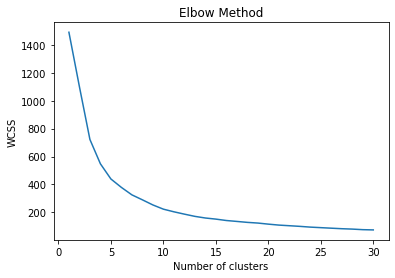

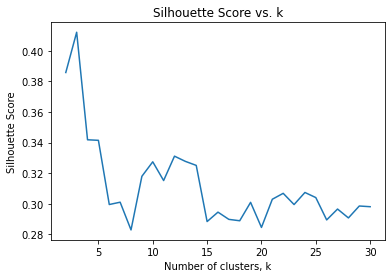

In [175]:
# determine K by Elbow Method
def elbow(k_no, data_scaled):
    wcss = []
    for i in range(1, k_no):  # Assuming we're testing k from 2 to k_no
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data_scaled)
        wcss.append(kmeans.inertia_)  

    # draw
    plt.plot(range(1, 31), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
def silhouette(k_no, data_scaled):
    silhouette_scores = []
    K = range(2, k_no)  # Assuming we're testing k from 2 to k_no

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_scaled)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(data_scaled, labels))

    
    plt.plot(K, silhouette_scores)
    plt.xlabel('Number of clusters, k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. k')
    plt.show()
def evaluate_k_no(k_no, data_scaled):
    elbow(k_no, data_scaled)
    silhouette(k_no, data_scaled)
    
evaluate_k_no(31,data_scaled)

In [140]:
portfolio_rts

[0.12598973030542596,
 0.025713631707365275,
 0.0909745707903971,
 0.02923764701004694,
 0.054805674471748306,
 0.0686029426320939,
 0.04356139124296436,
 -0.007366457778685882,
 -0.06149972035923276,
 -0.042174153598826994,
 0.1061319863820396]

In [141]:
index_rts

[0.0617528578346791,
 -0.0261124939318185,
 0.0350516125771089,
 0.014642341662481,
 0.0024823473681929,
 0.0647274649042346,
 0.0311389323550108,
 -0.017716390070854,
 -0.0487193674656248,
 -0.0219796887379829,
 0.0850732724625336]